### Author: Bogdan Bintu
### Date: 9/18/2022
#### This is inteded to download the DNA mm10 and produce the probes for two genomic loci in the heart: NppAB and Ifnas

### Step1: Download mm10 from ucsc genome browser:
http://hgdownload.soe.ucsc.edu/goldenPath/mm10/chromosomes/

uncompress using 7-zip on Windows

### Install visual studio compiler for Python if not installed.

#### The first time run bellow code to run in python

In [1]:
#!cd LibraryDesign3\C_Tools && python setup.py build_ext --inplace

In [2]:
import sys,os
sys.path.append(r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\LibraryDesign3')
import LibraryDesigner as ld
import LibraryTools as lt
from seqint import seq2Int, seq2Int_rc
# some other packages may required
import Bio #use pip install biopython

### Construct count tables -- only need to do it once

#### Count table for the genome

In [3]:
ct = ld.countTable(word=17,save_file=r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10\allgenome_17w.bin',sparse=False)
import glob
fasta_fls = glob.glob(r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10\*.fa')
for fl in fasta_fls:
    names,seqs = lt.fastaread(fl)
    for nm,sq in zip(names,seqs):
        print(nm)
        ct.consume(sq)
        
ct.complete(verbose=True)
ct.save()

chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr1_GL456210_random
chr1_GL456211_random
chr1_GL456212_random
chr1_GL456213_random
chr1_GL456221_random
chr2
chr3
chr4
chr4_GL456216_random
chr4_GL456350_random
chr4_JH584292_random
chr4_JH584293_random
chr4_JH584294_random
chr4_JH584295_random
chr5
chr5_GL456354_random
chr5_JH584296_random
chr5_JH584297_random
chr5_JH584298_random
chr5_JH584299_random
chr6
chr7
chr7_GL456219_random
chr8
chr9
chrM
chrUn_GL456239
chrUn_GL456359
chrUn_GL456360
chrUn_GL456366
chrUn_GL456367
chrUn_GL456368
chrUn_GL456370
chrUn_GL456372
chrUn_GL456378
chrUn_GL456379
chrUn_GL456381
chrUn_GL456382
chrUn_GL456383
chrUn_GL456385
chrUn_GL456387
chrUn_GL456389
chrUn_GL456390
chrUn_GL456392
chrUn_GL456393
chrUn_GL456394
chrUn_GL456396
chrUn_JH584304
chrX
chrX_GL456233_random
chrY
chrY_JH584300_random
chrY_JH584301_random
chrY_JH584302_random
chrY_JH584303_random
Time to compute unique and clip: 620.9252135753632
Time to update matrix: 7.764036655426

#### Count table for the transcriptome

In [5]:
ct = ld.countTable(word=17,save_file=r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10_transcriptome\mouse_GRCm39_genesUnspliced_17w.bin',
                   sparse=False)
fl = r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10_transcriptome\mouse_GRCm39_genesUnspliced.fasta'
names,seqs = lt.fastaread(fl)
from tqdm import tqdm
for sq in tqdm(seqs):
    ct.consume(sq,verbose=False)
ct.complete(verbose=True)
ct.save()

100%|███████████████████████████████████████████████████████████████████████████| 55416/55416 [05:20<00:00, 172.89it/s]


Time to compute unique and clip: 244.9631416797638
Time to update matrix: 5.145681619644165


In [2]:
#!pip install pyensembl
#!pyensembl install --release 104 --species mus_musculus
#!pip install pyliftover

In [3]:
import sys,os
sys.path.append(os.path.abspath(r'LibraryDesign3'))
import LibraryTools as lt
import numpy as np
from pyensembl import EnsemblRelease
class geneInfo():
    def __init__(self,transcript_file = r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10_transcriptome\mouse_GRCm39_genesUnspliced.fasta'):
        self.transcript_file = transcript_file
        
        self.names,self.seqs = lt.fastaread(transcript_file)
        self.data = EnsemblRelease(release=104,species='mus_musculus')
        
    def load(self,gn_name):
        self.gn_name = gn_name
        try:
            self.gns = self.data.genes_by_name(self.gn_name)
            self.gene = self.gns[0]
            len_seqs = [len(t.sequence) for t in self.gene.transcripts if t.sequence is not None]
        except:
            len_seqs=[]
        self.exon_sequence =''
        self.intron_sequence =''
        self.full_sq = ''
        if len(len_seqs):
            # select longest transcript
            self.transcript = self.gene.transcripts[np.argmax(len_seqs)]
            self.full_sq = [sq for nm,sq in zip(self.names,self.seqs) if self.gene.id in nm][0]
            self.strand = int(self.gene.strand=='-')
            self.exon_interv = np.array(self.transcript.exon_intervals)-self.gene.start if self.strand==0 else self.gene.end-np.array(self.transcript.exon_intervals)[:,::-1]

            bp_exon = [e_ for st,ed in self.exon_interv for e_ in np.arange(st,ed)]
            bp_intron = np.setdiff1d(np.arange(0,self.gene.end-self.gene.start),bp_exon)
            self.intron_interv = []
            if len(bp_intron):
                inz = np.where(np.diff(bp_intron)!=1)[0]
                self.intron_interv = np.array([[bp_intron[0]]+list(bp_intron[inz+1]),list(bp_intron[inz])+[bp_intron[-1]]]).T
            self.exon_sequence = self.transcript.sequence
            if len(self.intron_interv):
                self.intron_sequence = 'N'.join([self.full_sq[st:ed] for st,ed in self.intron_interv])

In [4]:
geneInfo_ = geneInfo()
geneInfo_.load('Nppa')

INFO:pyensembl.sequence_data:Loaded sequence dictionary from C:\Users\Bogdan\AppData\Local\pyensembl\GRCm39\ensembl104\pyensembl\GRCm39\ensembl104\Cache\Mus_musculus.GRCm39.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from C:\Users\Bogdan\AppData\Local\pyensembl\GRCm39\ensembl104\pyensembl\GRCm39\ensembl104\Cache\Mus_musculus.GRCm39.ncrna.fa.gz.pickle


In [12]:
geneInfo_.intron_sequence

'GGTAGGGCCAGGAAGTGGGACACAGACTGGGACCAGGGTCTCTTTGGTACTGGGTCCATTCCTGAGACGTCCCCTTTCTCTGTATTTATTTTGCCTTTATAAANGGTAAGAGGAGCTGTGGATGGAAATGGGATAGAGGTCAGGTGGGGTCTTGTTAGGGCTCAAACCTTGCCAAGGGACACTACCAGGGAGCATCTTTGGCAGCTGAGAGCCTGATGCATGTATCATTTTCTCTGTGAGTTCTTCCTCACTACGATGGGTGTCCCTTGAGTTTCAAGACAATGACAACAGCTGCTGCAGGGTCTGAGCCACAAGCACTGGGGAGTTAGAATACAGGGCCAAGACTGCCTCATTAATGCTTACCAGTGCCTTGCTTGCCGGTTTAATCACAGAGGCTAGACTGTGGCTTGTGGGAAATAGTTGATCGCTGTTCAAGTGGAACAATTTAGCCCAGTAAAGGCAGATCATCAAGCCAGTATATTTTTCTCTTTGTA'

In [21]:
(147800000-148700000)/5000

-180.0

In [17]:
(147800000-148200000)/5000

-80.0

In [ ]:
Chr4:148070264-148071662 #Nppb - http://www.informatics.jax.org/marker/MGI:97368
Chr4:148085179-148086531 #Nppa
#'chr4',147985000,147990000    

In [ ]:
https://tinyurl.com/2lpvxvao

In [ ]:
### NppAB locus: 'chr4',147800000,148200000

In [23]:
from pyliftover import LiftOver
lo = LiftOver('mm10', 'mm39')
chr_,start_mm10,end_mm10  = 'chr4',147800000,148200000
start_mm39 = lo.convert_coordinate(chr_, start_mm10)[0][1]
end_mm39 = lo.convert_coordinate(chr_, end_mm10)[0][1]
print('mm39::chr4:'+str(start_mm39)+'-'+str(end_mm39))

mm39::chr4:147884457-148284457


In [25]:
len(np.arange(start_mm39,end_mm39,30))

13334

### Scan the locus for genes

In [26]:
from tqdm.notebook import tqdm
allgn_ids = [gn_id for pos in tqdm(np.arange(start_mm39,end_mm39,30)) for gn_id in geneInfo_.data.gene_ids_at_locus('4',int(pos))]
allgn_ids = np.unique(allgn_ids)
#np.save(r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\data\gn_ids_in_Sall1Locus.npy',allgn_ids)

  0%|          | 0/13334 [00:00<?, ?it/s]

In [29]:
print(list(allgn_ids))

['ENSMUSG00000019055', 'ENSMUSG00000029001', 'ENSMUSG00000029003', 'ENSMUSG00000029005', 'ENSMUSG00000029007', 'ENSMUSG00000029009', 'ENSMUSG00000029016', 'ENSMUSG00000029019', 'ENSMUSG00000029020', 'ENSMUSG00000029022', 'ENSMUSG00000041556', 'ENSMUSG00000041616', 'ENSMUSG00000044496', 'ENSMUSG00000055401', 'ENSMUSG00000059423', 'ENSMUSG00000070583', 'ENSMUSG00000078494', 'ENSMUSG00000078495', 'ENSMUSG00000080059', 'ENSMUSG00000083340', 'ENSMUSG00000083473', 'ENSMUSG00000086806', 'ENSMUSG00000093594', 'ENSMUSG00000094320', 'ENSMUSG00000099043']


In [28]:
genes_in_locus = np.array([geneInfo_.data.gene_by_id(id_).gene_name for id_ in allgn_ids])
pos_genes = [geneInfo_.data.gene_by_id(id_).start for id_ in allgn_ids]
print(list(genes_in_locus[np.argsort(pos_genes)]))

['Zfp984', 'Gm20707', 'Rps19-ps3', 'Zfp933', 'Miip', 'Fv1', 'Mfn2', 'Gm13156', 'Plod1', '2510039O18Rik', 'Nppb', 'Nppa', 'Gm13054', 'Clcn6', 'Gm13207', 'Mthfr', 'Chchd2-ps', 'Gm13201', 'Agtrap', 'Draxin', 'Mad2l2', 'Fbxo6', 'Mir7022', 'Fbxo44', 'Fbxo2']


In [30]:
geneInfo_ = geneInfo()
for gn in genes_in_locus[np.argsort(pos_genes)]:
    geneInfo_.load(gn)
    #print(len(geneInfo_.gene.transcripts))
    
    print(gn,len(geneInfo_.intron_sequence),len(geneInfo_.exon_sequence))

INFO:pyensembl.sequence_data:Loaded sequence dictionary from C:\Users\Bogdan\AppData\Local\pyensembl\GRCm39\ensembl104\pyensembl\GRCm39\ensembl104\Cache\Mus_musculus.GRCm39.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from C:\Users\Bogdan\AppData\Local\pyensembl\GRCm39\ensembl104\pyensembl\GRCm39\ensembl104\Cache\Mus_musculus.GRCm39.ncrna.fa.gz.pickle


Zfp984 53090 2729
Gm20707 25008 2516
Rps19-ps3 0 426
Zfp933 21145 4238
Miip 6137 1909
Fv1 0 1380
Mfn2 26783 4341
Gm13156 0 321
Plod1 22925 4097
2510039O18Rik 3690 2731
Nppb 638 781
Nppa 494 865
Gm13054 2105 820
Clcn6 29386 5198
Gm13207 0 773
Mthfr 14413 6072
Chchd2-ps 0 462
Gm13201 3387 642
Agtrap 6978 3996
Draxin 27067 5200
Mad2l2 13787 1535
Fbxo6 4491 1938
Mir7022 0 61
Fbxo44 5858 1829
Fbxo2 4520 1288


In [ ]:
for gn in genes_in_locus[np.argsort(pos_genes)]:
    geneInfo_.load(gn)
    #print(len(geneInfo_.gene.transcripts))
    
    print(gn,len(geneInfo_.intron_sequence),len(geneInfo_.exon_sequence))

In [39]:
txt_expr = np.array([ln[:-1].split(',') for ln in open(r'C:\Users\Bogdan\Dropbox\Kevin_Heart_MERFISH\data/MERFISH_AVG_expression_ALL_genes_KING.csv','r')])
genes = [gn.replace('"','') for gn in list(txt_expr[1:,0])]
cell_types = list(txt_expr[0,1:])
M = np.array(txt_expr[1:,1:],dtype=float)


In [103]:
#import pickle
#dic_expr = pickle.load(open(r'C:/Users/Bogdan/Dropbox/ChrisGlass_Project/scRNAseq/microglia_expr_dic.pkl','rb'))

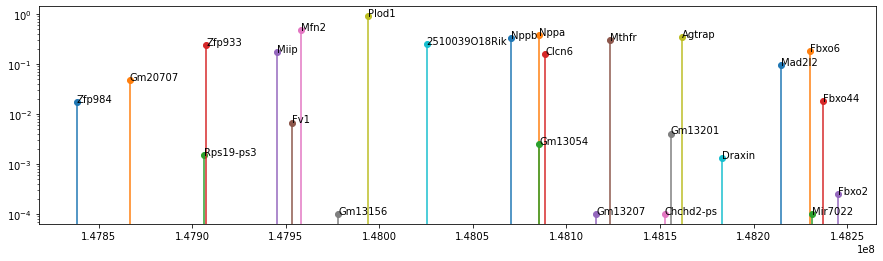

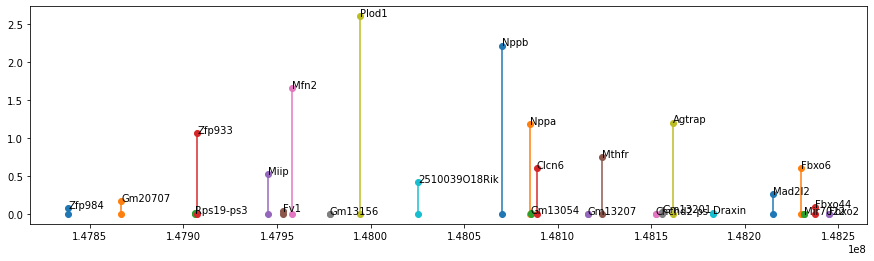

In [44]:
import matplotlib.pylab as plt
dic_expr = {gn:mn for mn,gn in zip(np.mean(M,axis=-1),genes)}
gns_,expr_,pos_ = zip(*[[gn,dic_expr.get(gn,0),pos] for gn,pos in zip(genes_in_locus[np.argsort(pos_genes)],np.sort(pos_genes))])
plt.figure(figsize=(15,4))
for gn,expr,pos in zip(gns_,expr_,pos_):
    plt.semilogy([pos,pos],[0,expr+0.0001],'o-')
    plt.text(pos,expr+0.0001,gn)
dic_expr = {gn:mn for mn,gn in zip(np.max(M,axis=-1),genes)}
gns_,expr_,pos_ = zip(*[[gn,dic_expr.get(gn,0),pos] for gn,pos in zip(genes_in_locus[np.argsort(pos_genes)],np.sort(pos_genes))])
plt.figure(figsize=(15,4))
for gn,expr,pos in zip(gns_,expr_,pos_):
    plt.plot([pos,pos],[0,expr+0.0001],'o-')
    plt.text(pos,expr+0.0001,gn)

In [47]:
gns_,expr_,pos_ =np.array(gns_),np.array(expr_),np.array(pos_)
genes_expressed_locus = list(gns_[expr_>0])
print("genes expressed locus:",genes_expressed_locus)

genes expressed locus: ['Zfp984', 'Gm20707', 'Rps19-ps3', 'Zfp933', 'Miip', 'Fv1', 'Mfn2', 'Plod1', '2510039O18Rik', 'Nppb', 'Nppa', 'Gm13054', 'Clcn6', 'Mthfr', 'Gm13201', 'Agtrap', 'Draxin', 'Mad2l2', 'Fbxo6', 'Fbxo44', 'Fbxo2']


In [48]:
#genes_near_Sall1 = list(gns_[np.abs(pos_ - pos_[gns_=='Sall1'])<7.5*10**5])
#print("genes near Sall1:",genes_near_Sall1)

In [49]:
intron_genes_ = list(np.unique(genes_expressed_locus))
print(intron_genes_)

['2510039O18Rik', 'Agtrap', 'Clcn6', 'Draxin', 'Fbxo2', 'Fbxo44', 'Fbxo6', 'Fv1', 'Gm13054', 'Gm13201', 'Gm20707', 'Mad2l2', 'Mfn2', 'Miip', 'Mthfr', 'Nppa', 'Nppb', 'Plod1', 'Rps19-ps3', 'Zfp933', 'Zfp984']


### Save sequences for the interesting genes in the locus

In [51]:
save_folder = r"C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing"
geneInfo_ = geneInfo()
for gn in intron_genes_:
    geneInfo_.load(gn)
    #print(len(geneInfo_.gene.transcripts))
    if len(geneInfo_.intron_sequence)>300:
        names = [gn+'_intron']
        seqs = [geneInfo_.intron_sequence]
        lt.fastawrite(save_folder+r'\seqs_genes'+os.sep+gn+'_intron.fa',names,seqs)
    elif len(geneInfo_.exon_sequence)>0:
        names = [gn+'_full']
        seqs = [geneInfo_.full_sq]
        lt.fastawrite(save_folder+r'\seqs_genes'+os.sep+gn+'_full.fa',names,seqs)
        
        names = [gn+'_exon']
        seqs = [geneInfo_.exon_sequence]
        lt.fastawrite(save_folder+r'\seqs_genes'+os.sep+gn+'_exon.fa',names,seqs)
    else:
        print("Failed:")
    print(gn,len(geneInfo_.intron_sequence),len(geneInfo_.exon_sequence))

INFO:pyensembl.sequence_data:Loaded sequence dictionary from C:\Users\Bogdan\AppData\Local\pyensembl\GRCm39\ensembl104\pyensembl\GRCm39\ensembl104\Cache\Mus_musculus.GRCm39.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from C:\Users\Bogdan\AppData\Local\pyensembl\GRCm39\ensembl104\pyensembl\GRCm39\ensembl104\Cache\Mus_musculus.GRCm39.ncrna.fa.gz.pickle


2510039O18Rik 3690 2731
Agtrap 6978 3996
Clcn6 29386 5198
Draxin 27067 5200
Fbxo2 4520 1288
Fbxo44 5858 1829
Fbxo6 4491 1938
Fv1 0 1380
Gm13054 2105 820
Gm13201 3387 642
Gm20707 25008 2516
Mad2l2 13787 1535
Mfn2 26783 4341
Miip 6137 1909
Mthfr 14413 6072
Nppa 494 865
Nppb 638 781
Plod1 22925 4097
Rps19-ps3 0 426
Zfp933 21145 4238
Zfp984 53090 2729


### Save the top genes in heart

In [198]:
r'C:\Users\Bogdan\Dropbox\Kevin_Heart_MERFISH\data\top_genes_heart.fa'
http://localhost:8888/notebooks/Dropbox/Kevin_Heart_MERFISH/Probe_design_Kevin.ipynb

### Save Locus

In [52]:
import sys,os
sys.path.append(os.path.abspath(r'LibraryDesign3'))
import LibraryDesigner as ld
import LibraryTools as lt
from seqint import seq2Int, seq2Int_rc
# some other packages may required
import Bio #use pip install biopython

In [54]:
geneInfo_ = geneInfo()
geneInfo_.load('Nppb')

INFO:pyensembl.sequence_data:Loaded sequence dictionary from C:\Users\Bogdan\AppData\Local\pyensembl\GRCm39\ensembl104\pyensembl\GRCm39\ensembl104\Cache\Mus_musculus.GRCm39.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from C:\Users\Bogdan\AppData\Local\pyensembl\GRCm39\ensembl104\pyensembl\GRCm39\ensembl104\Cache\Mus_musculus.GRCm39.ncrna.fa.gz.pickle


In [55]:
geneInfo_.gene

Gene(gene_id='ENSMUSG00000029019', gene_name='Nppb', biotype='protein_coding', contig='4', start=148070245, end=148071662, strand='+', genome='GRCm39')

In [58]:
(147884457-148284457)/5000

-80.0

In [83]:
from pyliftover import LiftOver
lo = LiftOver('mm39', 'mm10')
chr_,start_mm39,end_mm39  = 'chr4',147884457, 148284457
start_mm10 = lo.convert_coordinate(chr_, start_mm39)[0][1]
end_mm10 = lo.convert_coordinate(chr_, end_mm39)[0][1]
print('mm10::chr4:'+str(start_mm10)+'-'+str(end_mm10))

mm10::chr4:147800000-148200000


In [84]:
locus = lt.coords_to_seq('chr4:147800000-148200000',genome_folder=r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10',
                               save_file=r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\DNAseqs\NppAB_locus.fasta')

In [87]:
geneInfo_.load('Nppb')
locus.upper().index(geneInfo_.full_sq[:100])

185787

### Create subfiles at 20kb resolution of the Sall1 locus

In [88]:
fl = r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\DNAseqs\NppAB_locus.fasta'
resolution = 5000
import numpy as np
names,seqs = lt.fastaread(fl)
for name,seq in zip(names,seqs):
    _chr = name.split(':')[0]
    _start = int(name.split(':')[-1].split('-')[0])
    _end = int(name.split(':')[-1].split('-')[-1])
    nregs = int(len(seq)/resolution)
    sq = seq[:nregs*resolution]
    sq = np.reshape(list(sq),[-1,resolution])
    sqs = [''.join(sq_) for sq_ in sq]
    nm = '_'.join(map(str,[_chr,_start,_end,'res'+str(resolution)]))
    nms = [nm+'_reg'+str(i) for i in range(len(sqs))]
    for ireg,(nm_,sq_) in enumerate(zip(nms,sqs)):
        lt.fastawrite(fl.replace('.fasta','_'+str(ireg+1).zfill(4)+'_'+str(int(resolution/1000)))+'kb.fasta',[nm_],[sq_])

### Check the first 20kb locus

In [68]:
top_transcriptome_fl =  r'C:\Users\Bogdan\Dropbox\Kevin_Heart_MERFISH\data\top_genes_heart.fa'
nms,sqs  =lt.fastaread(top_transcriptome_fl)
[gn for gn in intron_genes_ if gn in nms]

[]

In [69]:
in_file = r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\DNAseqs\NppAB_locus_0001_5kb.fasta'

save_file = in_file.replace('.fasta','.pbr')

transcriptome_fl = r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10_transcriptome\mouse_GRCm39_genesUnspliced_17w.bin'
genome_fl = r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10\allgenome_17w.bin'
rep_fl = r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10\repetitive\repetitive.fasta'
top_transcriptome_fl =  r'C:\Users\Bogdan\Dropbox\Kevin_Heart_MERFISH\data\top_genes_heart.fa'
local_genome_fl = in_file


pb_designer = ld.pb_reports_class(
    sequence_dic={'file':in_file,'use_revc':True,'use_kmer':True},
    map_dic={'transcriptome':{'file':transcriptome_fl,'use_revc':False,'use_kmer':True},
             'top_transcriptome':{'file':top_transcriptome_fl,'use_revc':False,'use_kmer':True},
          'genome':{'file':genome_fl,'use_revc':True,'use_kmer':True},
          'repetitive':{'file':rep_fl,'use_revc':True,'use_kmer':True},
          'local_genome':{'file':in_file,'use_revc':True,'use_kmer':True}},
          #'local_genome':{'file':local_genome_fl,'force_list':True,'use_revc':True,'use_kmer':True}},
    save_file=save_file,
    params_dic={'word_size':17,'pb_len':40,'buffer_len':0,'max_count':2**16-1,'check_on_go':False,'auto':False},
    dic_check={('genome','local_genome'):75,
                'transcriptome':20,
                'top_transcriptome':5,
                'repetitive':2,'gc':[0.25,0.75],'tm':70})

pb_designer.computeOTmaps()
pb_designer.compute_pb_report(verbose=True)
pb_designer.perform_check_end()
pb_designer.plots()
pb_designer.save_csv(name=os.path.basename(in_file).split('.')[0])

Setting attribute: map_transcriptome
Setting attribute: map_top_transcriptome
Mapping no. of seqs: 1259
Setting attribute: map_genome
Setting attribute: map_repetitive
Mapping no. of seqs: 67029
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Time(s): 264.7487769126892
Dealing with sequence: 1 out of 1


100%|████████████████████████████████████████████████████████████████████████████| 4960/4960 [00:03<00:00, 1300.99it/s]


Time(s): 5.394914388656616
Picking non-overlaping sequences.
Time(s): 0.2652409076690674


### Design probes for the rest of the loci

In [89]:
import glob
in_files = glob.glob(r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\DNAseqs\*_locus_*_5kb.fasta')
print('Detected no. of files:'+str(len(in_files)))

Detected no. of files:203


In [90]:
in_files

['C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\DNAseqs\\Ifna_locus_0001_5kb.fasta',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\DNAseqs\\Ifna_locus_0002_5kb.fasta',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\DNAseqs\\Ifna_locus_0003_5kb.fasta',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\DNAseqs\\Ifna_locus_0004_5kb.fasta',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\DNAseqs\\Ifna_locus_0005_5kb.fasta',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\DNAseqs\\Ifna_locus_0006_5kb.fasta',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\DNAseqs\\Ifna_locus_0007_5kb.fasta',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\DNAseqs\\Ifna_locus_0008_5kb.fasta',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\DNAseqs\\Ifna_locus_0009_5kb.fasta',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\DNAseqs\\Ifna_locus_0010_5kb.fasta',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\DNAseqs\\Ifna_locus_0011_5kb.fasta',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\DNAse

In [91]:
from tqdm.notebook import tqdm
for in_file in tqdm(in_files):
    #print(in_file)
    #modify input file
    pb_designer.sequence_dic['file'] = in_file
    #modify save file
    pb_designer.save_file = in_file.replace('.fasta','.pbr')
    if not os.path.exists(pb_designer.save_file):
        pb_designer.load_sequence_file_and_paramaters()
        #modify maps
        key='local_genome'
        pb_designer.map_dic[key]['file'] = in_file
        pb_designer.files_to_OTmap("map_"+key,pb_designer.map_dic[key])
        #compute
        pb_designer.compute_pb_report()
        pb_designer.perform_check_end()
        pb_designer.plots()
        pb_designer.save_csv(name=os.path.basename(in_file).split('.')[0])

  0%|          | 0/203 [00:00<?, ?it/s]

Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.0338475704193115
Picking non-overlaping sequences.
Time(s): 0.14713358879089355
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.050278663635254
Picking non-overlaping sequences.
Time(s): 0.16715192794799805
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.0428659915924072
Picking non-overlaping sequences.
Time(s): 0.16514992713928223
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.0478601455688477
Picking non-overlaping sequences.
Time(s): 0.18216514587402344
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.0505259037017822
Picking non-overlaping sequences.
Time(s): 0.14413070678710938
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence:

Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.048668384552002
Picking non-overlaping sequences.
Time(s): 0.18516755104064941
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.0368504524230957
Picking non-overlaping sequences.
Time(s): 0.21719670295715332
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 1.9984335899353027
Picking non-overlaping sequences.
Time(s): 0.18416786193847656
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.02264142036438
Picking non-overlaping sequences.
Time(s): 0.2402188777923584
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.037850856781006
Picking non-overlaping sequences.
Time(s): 0.24522161483764648
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 o

Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.0318877696990967
Picking non-overlaping sequences.
Time(s): 0.16214680671691895
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.0418543815612793
Picking non-overlaping sequences.
Time(s): 0.14713335037231445
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.0708415508270264
Picking non-overlaping sequences.
Time(s): 0.16802740097045898
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.079535484313965
Picking non-overlaping sequences.
Time(s): 0.17616033554077148
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 2.052290201187134
Picking non-overlaping sequences.
Time(s): 0.15468430519104004
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 

### Check the probes designed

In [92]:
import os,glob
pb_folder = r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\DNAseqs'
pbr_files = glob.glob(pb_folder+os.sep+'*.pbr')


def get_pb_est(pbr_fl):
    pb_designer.load_pbr(pbr_fl)
    pb_reports = pb_designer.pb_reports
    pb_reports_keep = pb_designer.pb_reports_keep


    dic_check = pb_designer.dic_check
    dic_fracs = {}
    for key_ch in dic_check:
        if type(key_ch) is tuple:
            k0,k1 = key_ch[0],key_ch[1]
            x0 = np.array([pb_reports[key][k0] for key in pb_reports.keys()])
            x1 = np.array([pb_reports[key][k1] for key in pb_reports.keys()])
            x=x0-x1
            y0 = np.array([pb_reports_keep[key][k0] for key in pb_reports_keep.keys()])
            y1 = np.array([pb_reports_keep[key][k1] for key in pb_reports_keep.keys()])
            y=y0-y1
            kp_nm = key_ch[0]
        else:
            x = np.array([pb_reports[key][key_ch] for key in pb_reports.keys()])
            y = np.array([pb_reports_keep[key][key_ch] for key in pb_reports_keep.keys()])
            kp_nm = key_ch
        check_val = dic_check[key_ch]
        if type(check_val) is list:
            keep = (x>np.min(check_val))&(x<np.max(check_val))
        else:
            if key_ch=='tm':
                keep = x>=check_val
            else:
                keep = x<=check_val
        dic_fracs[kp_nm] = np.sum(keep)/float(len(keep))

    pb_len = pb_designer.params_dic['pb_len']
    buffer_len = pb_designer.params_dic['buffer_len']
    len_sq = np.max([pb_reports[kpb]['pb_index'] for kpb in pb_reports])+pb_len+1
    n_max = int(len_sq/(pb_len+buffer_len))
    dic_fracs['actual'] = len(pb_reports_keep)/float(n_max)
    return dic_fracs

In [93]:
dics = [get_pb_est(pbr_fl) for pbr_fl in pbr_files]

In [18]:
%matplotlib notebook

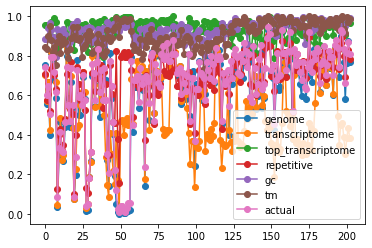

In [94]:
import matplotlib.pylab as plt
keys = dics[0].keys()
data_fracs = np.array([[dic[key] for dic in dics] for key in keys])
plt.figure()
for data_,key in zip(data_fracs,keys):
    plt.plot(data_,'o-',label=key)
plt.legend()
plt.show()

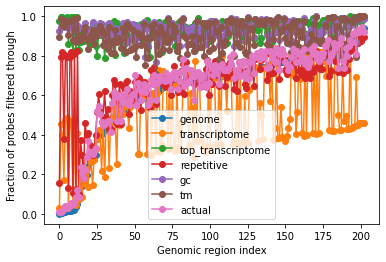

In [95]:
keys = dics[0].keys()
data_fracs = np.array([[dic[key] for dic in dics] for key in keys])
data_fracs = data_fracs[:,np.argsort(data_fracs[0,:])]
plt.figure()
for data_,key in zip(data_fracs,keys):
    plt.plot(data_,'o-',label=key)
plt.legend()
plt.ylabel("Fraction of probes filtered through")
plt.xlabel("Genomic region index")
plt.show()

### The stringency against the transcriptome is very high, in particular the top transcriptome. This seems to be limiting the number of probes probes

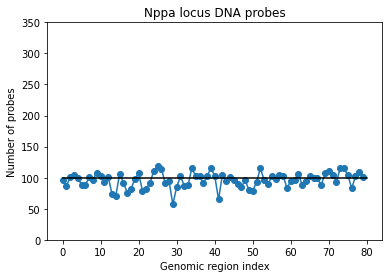

In [100]:
pb_folder = r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\DNAseqs'
nprobes = [len([ln for ln in open(fl,'r') if len(ln)>2])-1 
           for fl in glob.glob(pb_folder+r'\*Nppa*.csv')]

plt.figure()
plt.plot(nprobes,'o-')
plt.plot([0,len(nprobes)],[100,100],'k-')
plt.ylim([0,350])
plt.ylabel('Number of probes')
plt.xlabel("Genomic region index")
plt.title("Nppa locus DNA probes")
plt.show()

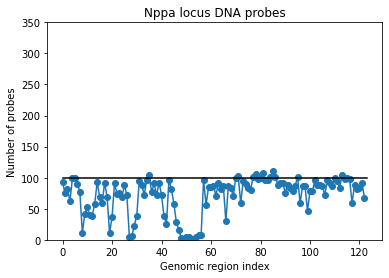

In [101]:
pb_folder = r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\DNAseqs'
nprobes = [len([ln for ln in open(fl,'r') if len(ln)>2])-1 
           for fl in glob.glob(pb_folder+r'\*Ifna*.csv')]

plt.figure()
plt.plot(nprobes,'o-')
plt.plot([0,len(nprobes)],[100,100],'k-')
plt.ylim([0,350])
plt.ylabel('Number of probes')
plt.xlabel("Genomic region index")
plt.title("Nppa locus DNA probes")
plt.show()

In [108]:
(np.array(nprobes)<25).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [137]:
def result_file(in_files,word=12):
    """
    writes results of homology to file replacing each filename .fasta -> _isoResults.results
    This file contains names of sequences with high homology, pvalue assuming Bernoulli, 
    fraction of orginal transcript homology, fraction of target trancript homology
    """
    import sys,os,glob
    sys.path.append(os.path.abspath(r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\LibraryDesign3'))
    import LibraryTools as lt
    import numpy as np
    import LibraryDesigner as ld
    import pickle
    from tqdm import tqdm
    def get_ints(sq,word = 12,verbose=True):
        ints = []
        if len(sq)>=word:
            sq_ = sq.encode()# encode to bytes
            iters = tqdm(range(len(sq_)-word+1)) if verbose else range(len(sq_)-word+1)
            for i in iters:
                ints.append(ld.seq2Int(sq_[i:i+word]))
        return ints
    
    ints_tr  = pickle.load(open(r'C:\Users\Bogdan\Dropbox\BrainWideLibrary\transcriptome_ints'+str(word)+'bp.pkl','rb'))
    lens_tr = [len(int_) for int_ in ints_tr]
    names_tr = np.load(r'C:\Users\Bogdan\Dropbox\BrainWideLibrary\names_transcriptome.npy')
    for fl in tqdm(in_files):
        tag = fl.split('.')[-1]
        fl_ = fl.replace('.'+tag,'_isoResults.results')
        if not os.path.exists(fl_):
            sq_T = lt.fastaread(fl)[-1][0]
            word=12
            lens_ = lens_tr
            ints__ = ints_tr
            names__ = names_tr
            intT = np.unique(get_ints(sq_T,word = word,verbose=False)[::word])
            CT = np.array([np.in1d(intT,int_,assume_unique=True) for int_ in tqdm(ints__)])
            logprand = np.log(np.sum(CT[:,:]))-np.log(np.sum(lens_))-np.log(CT.shape[-1])
            from scipy.stats import binomtest
            pvalues = []
            for itr in np.arange(len(CT)):
                pvalue=1
                if lens_[itr]>0:
                    result = binomtest(np.sum(CT[itr]), n=lens_[itr], p=np.exp(logprand+np.log(CT.shape[-1])), alternative='greater')
                    pvalue = result.pvalue
                pvalues.append(pvalue)
            ibest = np.argsort(np.log(pvalues))[:500]
            result = [(names__[ib],pvalues[ib],np.mean(CT[ib]),np.sum(CT[ib])/lens_[ib]*word) for ib in ibest]
            text = '\n'.join([','.join([str(e) for e in ln]) for ln in result])

            fid = open(fl_,'w')
            fid.write(text)
            fid.close()

In [134]:
in_files = glob.glob(r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_NPPA\*.fa')+\
glob.glob(r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_IFNA\*.fa')

In [138]:
result_file(in_files,word=12)

100%|██████████████████████████████████████████████████████████████████████████| 55416/55416 [00:11<00:00, 4866.03it/s]
C:\Users\Bogdan\AppData\Local\Temp/ipykernel_20744/1783343363.py:46: RuntimeWarning: divide by zero encountered in log
  ibest = np.argsort(np.log(pvalues))[:500]
 10%|███████▊                                                                   | 5762/55416 [00:02<00:20, 2391.07it/s]


 20%|██████████████▌                                                           | 10908/55416 [00:04<00:23, 1934.95it/s]


 27%|████████████████████                                                      | 14998/55416 [00:06<00:17, 2288.27it/s]


 49%|████████████████████████████████████▍                                     | 27269/55416 [00:08<00:02, 9615.12it/s]


  1%|▍                                                                           | 302/55416 [00:00<00:18, 3017.25it/s]


 13%|█████████▊                                                                 | 7267/55416 [00:03<00:21, 2267.34it/s]


 26%|███████████████████▌                                                      | 14637/55416 [00:06<00:15, 2655.19it/s]


 61%|████████████████████████████████████████████▋                            | 33884/55416 [00:09<00:02, 10215.15it/s]


  4%|███▏                                                                       | 2393/55416 [00:00<00:21, 2435.62it/s]


 12%|█████████▎                                                                 | 6886/55416 [00:02<00:22, 2153.27it/s]


 21%|███████████████▎                                                          | 11496/55416 [00:05<00:26, 1664.17it/s]


 29%|█████████████████████▏                                                    | 15843/55416 [00:07<00:18, 2164.46it/s]


 60%|████████████████████████████████████████████▋                             | 33457/55416 [00:09<00:02, 8994.27it/s]


  4%|███▎                                                                       | 2485/55416 [00:00<00:21, 2482.47it/s]


 16%|███████████▉                                                               | 8861/55416 [00:03<00:20, 2241.91it/s]


 25%|██████████████████▋                                                       | 13965/55416 [00:05<00:14, 2944.21it/s]


 59%|███████████████████████████████████████████▏                             | 32815/55416 [00:09<00:02, 10609.38it/s]


  1%|█                                                                           | 757/55416 [00:00<00:22, 2435.87it/s]


  5%|███▊                                                                       | 2824/55416 [00:01<00:22, 2315.50it/s]


 17%|████████████▊                                                              | 9465/55416 [00:04<00:20, 2244.93it/s]


 29%|█████████████████████▍                                                    | 16073/55416 [00:07<00:17, 2223.37it/s]


 75%|██████████████████████████████████████████████████████▉                  | 41737/55416 [00:09<00:01, 12728.03it/s]


 10%|███████▊                                                                   | 5796/55416 [00:02<00:20, 2453.23it/s]


 25%|██████████████████▋                                                       | 13986/55416 [00:05<00:13, 3043.74it/s]


 58%|██████████████████████████████████████████▍                              | 32180/55416 [00:09<00:02, 10711.34it/s]


  4%|██▋                                                                        | 1965/55416 [00:00<00:19, 2719.19it/s]


 17%|████████████▊                                                              | 9438/55416 [00:03<00:19, 2331.76it/s]


 31%|██████████████████████▉                                                   | 17190/55416 [00:07<00:14, 2584.84it/s]


 89%|█████████████████████████████████████████████████████████████████▏       | 49486/55416 [00:10<00:00, 14728.20it/s]


 11%|████████                                                                   | 5993/55416 [00:02<00:20, 2373.27it/s]


 24%|█████████████████▋                                                        | 13261/55416 [00:05<00:15, 2689.70it/s]


 57%|█████████████████████████████████████████▊                               | 31712/55416 [00:08<00:02, 11030.37it/s]


  4%|███▎                                                                       | 2484/55416 [00:00<00:21, 2484.81it/s]


 18%|█████████████▎                                                             | 9866/55416 [00:04<00:21, 2090.66it/s]


 32%|███████████████████████▌                                                  | 17652/55416 [00:07<00:13, 2774.97it/s]


 94%|████████████████████████████████████████████████████████████████████▊    | 52210/55416 [00:10<00:00, 15114.81it/s]


 12%|█████████                                                                  | 6683/55416 [00:02<00:21, 2286.39it/s]


 26%|███████████████████▎                                                      | 14419/55416 [00:06<00:14, 2834.78it/s]


 65%|███████████████████████████████████████████████▉                          | 35854/55416 [00:09<00:02, 9102.20it/s]


  7%|█████▌                                                                     | 4098/55416 [00:01<00:24, 2127.18it/s]


 19%|██████████████                                                            | 10504/55416 [00:04<00:22, 2035.30it/s]


 31%|███████████████████████▏                                                  | 17324/55416 [00:07<00:14, 2572.56it/s]


 80%|██████████████████████████████████████████████████████████▌              | 44411/55416 [00:10<00:00, 13358.47it/s]


  9%|██████▍                                                                    | 4766/55416 [00:02<00:24, 2095.56it/s]


 21%|███████████████▋                                                          | 11779/55416 [00:05<00:21, 2039.90it/s]


 45%|█████████████████████████████████                                        | 25070/55416 [00:08<00:03, 10078.91it/s]


  2%|█▋                                                                         | 1208/55416 [00:00<00:19, 2837.00it/s]


 15%|██████████▉                                                                | 8113/55416 [00:03<00:20, 2336.49it/s]


 26%|███████████████████▏                                                      | 14381/55416 [00:06<00:15, 2678.54it/s]


 61%|████████████████████████████████████████████▊                            | 34037/55416 [00:09<00:01, 10793.67it/s]


  7%|█████▏                                                                     | 3849/55416 [00:01<00:23, 2204.08it/s]


 19%|██████████████                                                            | 10517/55416 [00:04<00:21, 2050.93it/s]


 31%|███████████████████████                                                   | 17243/55416 [00:07<00:15, 2513.65it/s]


 56%|█████████████████████████████████████████▎                                | 30972/55416 [00:10<00:02, 8474.20it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [15:36<00:00, 13.78s/it]


In [ ]:
import sys,os,glob
sys.path.append(os.path.abspath(r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\LibraryDesign3'))
import LibraryTools as lt
import numpy as np
import LibraryDesigner as ld
import pickle
from tqdm import tqdm

In [139]:
transcript_file = r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10_transcriptome\mouse_GRCm39_genesUnspliced.fasta'
names_tr,seqs_tr = lt.fastaread(transcript_file)

In [140]:
top_transcriptome_fl =  r'C:\Users\Bogdan\Dropbox\Kevin_Heart_MERFISH\data\top_genes_heart.fa'
names_top,seqs_top = lt.fastaread(top_transcriptome_fl)

In [141]:
fls = [fl.replace('.fa','_isoResults.results') for fl in in_files]
for fl in tqdm(fls):
    M = np.array([ln[:-1].split(',') for ln in open(fl,'r')])
    pval,fr1,fr2=M[:,1:].astype(np.float32).T
    names_ = M[:,0]
    keep = (np.log(pval)<np.log(10**(-3)))&(fr1>0.33)
    if True: #np.sum(keep)>1:
        print(fl)
        print(list(zip(names_[keep],pval[keep],fr1[keep],fr2[keep])))
        print()
    fl_save = fl.replace('_isoResults.results','_AutoIso.fasta')
    inds_iso = [names_tr.index(nm) for nm in names_[keep]]
    names_new = [names_tr[itr] for itr in inds_iso]
    seqs_new = [seqs_tr[itr] for itr in inds_iso]
    lt.fastawrite(fl_save,names_new,seqs_new)
    
    inds_iso_top = [names_tr.index(nm) for nm in names_[keep] if nm in names_top]
    names_new = [names_tr[itr] for itr in inds_iso_top]
    seqs_new = [seqs_tr[itr] for itr in inds_iso_top]
    lt.fastawrite(fl_save.replace('_AutoIso.fasta','_AutoIsoTop.fasta'),names_new,seqs_new)

  0%|          | 0/68 [00:00<?, ?it/s]

C:\Users\Bogdan\AppData\Local\Temp/ipykernel_20744/2072168385.py:6: RuntimeWarning: divide by zero encountered in log
  keep = (np.log(pval)<np.log(10**(-3)))&(fr1>0.33)


C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_NPPA\2510039O18Rik_intron_isoResults.results
[('ENSMUSG00000044496|ENSMUST00000103232|2510039O18Rik|4|148025352|148031771|1', 0.0, 0.99674267, 0.5735708)]

C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_NPPA\Agtrap_intron_isoResults.results
[('ENSMUSG00000029007|ENSMUST00000030865;ENSMUST00000152323;ENSMUST00000137393|Agtrap|4|148161518|148172488|-1', 0.0, 0.9948186, 0.64279735)]

C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_NPPA\Clcn6_intron_isoResults.results
[('ENSMUSG00000029016|ENSMUST00000030879;ENSMUST00000137724;ENSMUST00000105711;ENSMUST00000131232;ENSMUST00000134377|Clcn6|4|148088716|148123278|-1', 0.0, 0.99174917, 0.8666446)]

C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_NPPA\Draxin_intron_isoResults.results
[('ENSMUSG00000029005|ENSMUST00000030862|Draxin|4|148182894|148215155|-1', 0.0, 0.99775684, 0.85172653)]

C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_NPPA\Fbxo2_intron_isoResults.results


C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_IFNA\Ifna16_exon_isoResults.results
[('ENSMUSG00000078355|ENSMUST00000105148|Ifna16|4|88594152|88595161|-1', 0.0, 1.0, 1.0121951)]

C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_IFNA\Ifna16_full_isoResults.results
[('ENSMUSG00000078355|ENSMUST00000105148|Ifna16|4|88594152|88595161|-1', 0.0, 1.0, 1.0121951)]

C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_IFNA\Ifna1_exon_isoResults.results
[('ENSMUSG00000095498|ENSMUST00000094972|Ifna1|4|88768324|88768893|1', 0.0, 1.0, 1.0089445), ('ENSMUSG00000096682|ENSMUST00000102804|Ifna5|4|88753762|88754331|1', 0.0, 0.59574467, 0.6010733), ('ENSMUSG00000073811|ENSMUST00000102806|Ifna12|4|88520817|88521613|-1', 0.0, 0.61702126, 0.4427481), ('ENSMUSG00000101252|ENSMUST00000105146|Ifna6|4|88745653|88746222|1', 0.0, 0.5531915, 0.5591398), ('ENSMUSG00000095896|ENSMUST00000102808|Ifna14|4|88489466|88490035|-1', 0.0, 0.5531915, 0.55813956), ('ENSMUSG00000100713|ENSMUST00000105143|Ifna7|4|88

C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_IFNA\Ifna9_full_isoResults.results
[('ENSMUSG00000095270|ENSMUST00000102807|Ifna9|4|88510050|88510622|-1', 0.0, 1.0, 1.0053476), ('ENSMUSG00000101252|ENSMUST00000105146|Ifna6|4|88745653|88746222|1', 0.0, 0.5106383, 0.516129), ('ENSMUSG00000073811|ENSMUST00000102806|Ifna12|4|88520817|88521613|-1', 0.0, 0.5106383, 0.36641222), ('ENSMUSG00000096682|ENSMUST00000102804|Ifna5|4|88753762|88754331|1', 0.0, 0.4680851, 0.47227192), ('ENSMUSG00000095498|ENSMUST00000094972|Ifna1|4|88768324|88768893|1', 0.0, 0.42553192, 0.4293381), ('ENSMUSG00000096011|ENSMUST00000102809|Ifna15|4|88475910|88476482|-1', 0.0, 0.42553192, 0.42704627), ('ENSMUSG00000095896|ENSMUST00000102808|Ifna14|4|88489466|88490035|-1', 0.0, 0.40425533, 0.4078712), ('ENSMUSG00000100713|ENSMUST00000105143|Ifna7|4|88734465|88735037|1', 0.0, 0.40425533, 0.4064171), ('ENSMUSG00000100079|ENSMUST00000071378|Ifnab|4|88608539|88609596|-1', 0.0, 0.38297874, 0.20630373), ('ENSMUSG0000010054

In [142]:
in_files

['C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\seqs_genes_NPPA\\2510039O18Rik_intron.fa',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\seqs_genes_NPPA\\Agtrap_intron.fa',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\seqs_genes_NPPA\\Clcn6_intron.fa',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\seqs_genes_NPPA\\Draxin_intron.fa',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\seqs_genes_NPPA\\Fbxo2_intron.fa',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\seqs_genes_NPPA\\Fbxo44_intron.fa',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\seqs_genes_NPPA\\Fbxo6_intron.fa',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\seqs_genes_NPPA\\Fv1_exon.fa',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\seqs_genes_NPPA\\Fv1_full.fa',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\seqs_genes_NPPA\\Gm13054_intron.fa',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\seqs_genes_NPPA\\Gm13201_intron.fa',
 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\seqs_genes_NPPA\\Gm2

In [ ]:
in_file = r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\DNAseqs\NppAB_locus_0001_5kb.fasta'

save_file = in_file.replace('.fasta','.pbr')

transcriptome_fl = r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10_transcriptome\mouse_GRCm39_genesUnspliced_17w.bin'
genome_fl = r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10\allgenome_17w.bin'
rep_fl = r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10\repetitive\repetitive.fasta'
top_transcriptome_fl =  r'C:\Users\Bogdan\Dropbox\Kevin_Heart_MERFISH\data\top_genes_heart.fa'
local_genome_fl = in_file


pb_designer = ld.pb_reports_class(
    sequence_dic={'file':in_file,'use_revc':True,'use_kmer':True},
    map_dic={'transcriptome':{'file':transcriptome_fl,'use_revc':False,'use_kmer':True},
             'top_transcriptome':{'file':top_transcriptome_fl,'use_revc':False,'use_kmer':True},
          'genome':{'file':genome_fl,'use_revc':True,'use_kmer':True},
          'repetitive':{'file':rep_fl,'use_revc':True,'use_kmer':True},
          'local_genome':{'file':in_file,'use_revc':True,'use_kmer':True}},
          #'local_genome':{'file':local_genome_fl,'force_list':True,'use_revc':True,'use_kmer':True}},
    save_file=save_file,
    params_dic={'word_size':17,'pb_len':40,'buffer_len':0,'max_count':2**16-1,'check_on_go':False,'auto':False},
    dic_check={('genome','local_genome'):75,
                'transcriptome':20,
                'top_transcriptome':5,
                'repetitive':2,'gc':[0.25,0.75],'tm':70})

pb_designer.computeOTmaps()
pb_designer.compute_pb_report(verbose=True)
pb_designer.perform_check_end()
pb_designer.plots()
pb_designer.save_csv(name=os.path.basename(in_file).split('.')[0])

In [ ]:
import LibraryDesigner as ld
in_file = str(in_files[0])
in_file = r'C:\Users\Bogdan\Dropbox\BrainWideLibrary\data\1110008P14Rik_exons.fasta'
save_file = in_file.replace('.fasta','.pbr')
print(in_file)
transcriptome_fl = r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10_transcriptome\mouse_GRCm39_genesUnspliced_17w.bin'
genome_fl = r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10\allgenome_17w.bin'
rep_fl = r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\mm10\repetitive\repetitive.fasta'
top_transcriptome_fl =  r'C:\Users\Bogdan\Dropbox\Kevin_Heart_MERFISH\data\top_genes_heart.fa'

iso_file_top = in_file.replace('.fasta','_AutoIsoTop.fasta')
iso_file = in_file.replace('.fasta','_AutoIso.fasta') 

dic_check={('transcriptome','local_transcript'):15,
            ('top_transcriptome','local_transcript_top'):0,
            'repetitive':0,'gc':[0.25,0.75],'tm':70}

pb_designer = ld.pb_reports_class(
    sequence_dic={'file':in_file,'use_revc':False,'use_kmer':True},
    map_dic={'transcriptome':{'file':transcriptome_fl,'use_revc':False,'use_kmer':True},
             'top_transcriptome':{'file':top_transcriptome_fl,'use_revc':False,'use_kmer':True},
          'repetitive':{'file':rep_fl,'use_revc':True,'use_kmer':True},
          'local_transcript':{'file':iso_file,'use_revc':False,'use_kmer':True},
            'local_transcript_top':{'file':iso_file_top,'use_revc':False,'use_kmer':True}},
          #'local_genome':{'file':local_genome_fl,'force_list':True,'use_revc':True,'use_kmer':True}},
    save_file=save_file,
    params_dic={'word_size':17,'pb_len':40,'buffer_len':0,'max_count':2**16-1,'check_on_go':False,'auto':False},
    dic_check=dic_check)

pb_designer.computeOTmaps()
pb_designer.compute_pb_report(verbose=True)
pb_designer.perform_check_end()
pb_designer.plots()
pb_designer.save_csv(name=os.path.basename(in_file).split('.')[0])

{'file': 'C:\\Users\\Bogdan\\Dropbox\\Kevin_DNA_tracing\\DNAseqs\\NppAB_locus_0080_5kb.fasta',
 'use_revc': True,
 'use_kmer': True}

In [149]:
from tqdm.notebook import tqdm
for in_fileT in tqdm(in_files[:]):
    in_file  = str(in_fileT)
    #print(in_file)
    #modify input file
    pb_designer.sequence_dic['use_revc']=False
    pb_designer.sequence_dic['file'] = in_file
    #modify save file
    pb_designer.save_file = in_file.replace('.fa','.pbr')
    pb_designer.params_dic = {'word_size':17,'pb_len':40,'buffer_len':0,'max_count':2**16-1,'check_on_go':False,'auto':False}
    
    iso_file_top = in_file.replace('.fa','_AutoIsoTop.fasta')
    iso_file = in_file.replace('.fa','_AutoIso.fasta') 
    for fl_ in [iso_file_top,iso_file]:
        if not os.path.exists(fl_):
            fid = open(fl_,'w')
            fid.close()
        
    #gene = os.path.basename(in_file).split('_')[0]

    pb_designer.dic_check={('genome','local_genome'):75,('transcriptome','local_transcript'):15,
            ('top_transcriptome','local_transcript_top'):5,
            'repetitive':0,'gc':[0.25,0.75],'tm':70}
    
    if True:#not os.path.exists(pb_designer.save_file):
        pb_designer.load_sequence_file_and_paramaters()
        #modify maps
        key='local_transcript'
        if key not in pb_designer.map_dic: pb_designer.map_dic[key]={'file': '','use_revc': False,'use_kmer': True}
        pb_designer.map_dic[key]['file'] = iso_file
        pb_designer.files_to_OTmap("map_"+key,pb_designer.map_dic[key])
        
        key='local_transcript_top'
        if key not in pb_designer.map_dic: pb_designer.map_dic[key]={'file': '','use_revc': False,'use_kmer': True}
        pb_designer.map_dic[key]['file'] = iso_file_top
        pb_designer.files_to_OTmap("map_"+key,pb_designer.map_dic[key])
        
        key='local_genome'
        if key not in pb_designer.map_dic: pb_designer.map_dic[key]={'file': '','use_revc': False,'use_kmer': True}
        pb_designer.map_dic[key]['file'] = iso_file
        pb_designer.files_to_OTmap("map_"+key,pb_designer.map_dic[key])
        
        
        #compute
        pb_designer.compute_pb_report()
        pb_designer.perform_check_end()
        pb_designer.plots()
        pb_designer.save_csv(name=os.path.basename(in_file).split('.')[0])

  0%|          | 0/68 [00:00<?, ?it/s]

Setting attribute: map_local_transcript
Mapping no. of seqs: 1
Setting attribute: map_local_transcript_top
Mapping no. of seqs: 0
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 0.9048218727111816
Picking non-overlaping sequences.
Time(s): 0.1040945053100586
Setting attribute: map_local_transcript
Mapping no. of seqs: 1
Setting attribute: map_local_transcript_top
Mapping no. of seqs: 0
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 1.6274778842926025
Picking non-overlaping sequences.
Time(s): 0.12010884284973145
Setting attribute: map_local_transcript
Mapping no. of seqs: 1
Setting attribute: map_local_transcript_top
Mapping no. of seqs: 0
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 8.433655023574829
Picking non-overlaping sequences.
Time(s): 0.5935385227203369
Setting attribute: map_local_transcript
Mapping no. of seqs: 

Setting attribute: map_local_transcript_top
Mapping no. of seqs: 0
Setting attribute: map_local_genome
Mapping no. of seqs: 8
Dealing with sequence: 1 out of 1
Time(s): 0.14713358879089355
Picking non-overlaping sequences.
Time(s): 0.01601576805114746
Setting attribute: map_local_transcript
Mapping no. of seqs: 8
Setting attribute: map_local_transcript_top
Mapping no. of seqs: 0
Setting attribute: map_local_genome
Mapping no. of seqs: 8
Dealing with sequence: 1 out of 1
Time(s): 0.12511324882507324
Picking non-overlaping sequences.
Time(s): 0.014012575149536133
Setting attribute: map_local_transcript
Mapping no. of seqs: 10
Setting attribute: map_local_transcript_top
Mapping no. of seqs: 0
Setting attribute: map_local_genome
Mapping no. of seqs: 10
Dealing with sequence: 1 out of 1
Time(s): 0.17716050148010254
Picking non-overlaping sequences.
Time(s): 0.020018339157104492
Setting attribute: map_local_transcript
Mapping no. of seqs: 10
Setting attribute: map_local_transcript_top
Mappin

Time(s): 0.24422168731689453
Picking non-overlaping sequences.
Time(s): 0.06706094741821289
Setting attribute: map_local_transcript
Mapping no. of seqs: 1
Setting attribute: map_local_transcript_top
Mapping no. of seqs: 0
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 0.245222806930542
Picking non-overlaping sequences.
Time(s): 0.02502274513244629
Setting attribute: map_local_transcript
Mapping no. of seqs: 1
Setting attribute: map_local_transcript_top
Mapping no. of seqs: 0
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 0.16915345191955566
Picking non-overlaping sequences.
Time(s): 0.013012170791625977
Setting attribute: map_local_transcript
Mapping no. of seqs: 1
Setting attribute: map_local_transcript_top
Mapping no. of seqs: 0
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Dealing with sequence: 1 out of 1
Time(s): 0.16414928436279297
Picking non-overlaping sequ

In [ ]:
pb_designer.map_dic[key]

In [151]:
print(in_file)

C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_IFNA\Wincr1_intron.fa


### Finalyze library

In [3]:
import sys,os
sys.path.append(os.path.abspath(r'LibraryDesign3'))
import sys,os
sys.path.append(r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\LibraryDesign3')
import LibraryTools as lt
import numpy as np
def read_target_seqs(fl):
    txts = np.array([ln.replace('\n','').split(',') for ln in open(fl,'r') if len(ln)>2][1:])
    seqs = np.array([txt.replace("'",'')[1:] for txt in txts[:,0]])
    names = txts[:,1]
    return names,seqs

import numpy as np,glob


txts = [ln.replace('\n','').split(',') for ln in open(r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\readouts_primers\NDB_brightness2.csv','r') if len(ln)>2]
head = txts[0]
txts = np.array(txts)[1:]
ndbs_info = np.array([r for r1,r2,r3 in zip(txts[txts[:,1]=='750'],txts[txts[:,1]=='647'],txts[txts[:,1]=='561']) for r in [r1,r2,r3]])

pcr_primers = np.array([ln.replace('\n','').split(',') for ln in open(r'C:\Users\Bogdan\Dropbox\ChrisGlass_Project\readouts_primers\PCR_primers - pcr.csv','r') if len(ln)>2][1:])


### Add readouts and primers

In [23]:
import glob
pb_folder = r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\DNAseqs'
files_ = np.sort(glob.glob(pb_folder+r'\*Npp*.csv'))
print(len(files_))
iNDB = 42
ipA,ipB = 1+5,1+10+2

lib_names = []
lib_seqs = []
final_primers_used = []

#get PCR primers

primerAnm,primerBnm = pcr_primers[[ipA,ipB],0]
primerAnm = primerAnm.split('_')[0]
primerBnm = primerBnm.split('_')[0]
primerA,primerB=pcr_primers[[ipA,ipB],-1]
primerB = lt.seqrc(primerB[-20:])

tag_lib = 'DNA__'+primerAnm+'__'+primerBnm

for fl in files_:
    names,seqs = read_target_seqs(fl)
    names = names[:92]
    seqs = seqs[:92]
    ndb_sq = ndbs_info[iNDB][-1]
    ndb_nm = ndbs_info[iNDB][0]
    tag = tag_lib+'__'+ndb_nm+'__'
    seqs = [lt.up_down([primerA,ndb_sq,lt.seqrc(sq),ndb_sq,ndb_sq,primerB]) for sq in seqs]
    print(len(seqs))
    names = [tag+nm for nm in names]
    iNDB+=1
    lib_names.extend(names)
    lib_seqs.extend(seqs)

    
if False:
    pb_folder = r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\DNAseqs'
    files_ = np.sort(glob.glob(pb_folder+r'\*Ifn*.csv'))
    print(len(files_))

    ipA,ipB = ipA+2,ipB+2
    iNDB = 42

    #get PCR primers

    primerAnm,primerBnm = pcr_primers[[ipA,ipB],0]
    primerAnm = primerAnm.split('_')[0]
    primerBnm = primerBnm.split('_')[0]
    primerA,primerB=pcr_primers[[ipA,ipB],-1]
    primerB = lt.seqrc(primerB[-20:])
    tag_lib = 'DNA__'+primerAnm+'__'+primerBnm


    for fl in files_:
        names,seqs = read_target_seqs(fl)
        if len(seqs)>25:
            ndb_sq = ndbs_info[iNDB][-1]
            ndb_nm = ndbs_info[iNDB][0]
            tag = tag_lib+'__'+ndb_nm+'__'
            seqs = [lt.up_down([primerA,ndb_sq,lt.seqrc(sq),ndb_sq,ndb_sq,primerB]) for sq in seqs]
            names = [tag+nm for nm in names]
            iNDB+=1
            lib_names.extend(names)
            lib_seqs.extend(seqs)    

        
        
pb_folder = r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_NPPA'
files_ = np.sort(glob.glob(pb_folder+r'\*.csv'))
files_ = list({os.path.basename(fl).split('_')[0]:fl for fl in files_}.values())
print(len(files_))

ipA,ipB = ipA+2,ipB+2
#get PCR primers



primerAnm,primerBnm = pcr_primers[[ipA,ipB],0]
primerAnm = primerAnm.split('_')[0]
primerBnm = primerBnm.split('_')[0]
primerA,primerB=pcr_primers[[ipA,ipB],-1]
primerB = lt.seqrc(primerB[-20:])
tag_lib = 'RNA1__'+primerAnm+'__'+primerBnm

for fl in files_:
    names,seqs = read_target_seqs(fl)
    if len(seqs)>5:
        names = names[:60]
        seqs = seqs[:60]
        
        ndb_sq = ndbs_info[iNDB][-1]
        ndb_nm = ndbs_info[iNDB][0]
        tag = tag_lib+'__'+ndb_nm+'__'

        seqs = [lt.up_down([primerA,ndb_sq,lt.seqrc(sq),ndb_sq,ndb_sq,primerB]) for sq in seqs]
        names = [tag+nm for nm in names]
        iNDB+=1
        lib_names.extend(names)
        lib_seqs.extend(seqs)
        
if False:
    pb_folder = r'C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\seqs_genes_IFNA'
    files_ = np.sort(glob.glob(pb_folder+r'\*.csv'))
    files_ = list({os.path.basename(fl).split('_')[0]:fl for fl in files_}.values())
    print(len(files_))
    ipA,ipB = ipA+2,ipB+2
    #get PCR primers


    primerAnm,primerBnm = pcr_primers[[ipA,ipB],0]
    primerAnm = primerAnm.split('_')[0]
    primerBnm = primerBnm.split('_')[0]
    primerA,primerB=pcr_primers[[ipA,ipB],-1]
    primerB = lt.seqrc(primerB[-20:])
    tag_lib = 'RNA2__'+primerAnm+'__'+primerBnm


    for fl in files_:
        names,seqs = read_target_seqs(fl)
        if len(seqs)>5:
            names = names[:60]
            seqs = seqs[:60]

            ndb_sq = ndbs_info[iNDB][-1]
            ndb_nm = ndbs_info[iNDB][0]
            tag = tag_lib+'__'+ndb_nm+'__'

            seqs = [lt.up_down([primerA,ndb_sq,lt.seqrc(sq),ndb_sq,ndb_sq,primerB]) for sq in seqs]
            names = [tag+nm for nm in names]
            iNDB+=1
            lib_names.extend(names)
            lib_seqs.extend(seqs)

80
92
86
92
92
92
89
88
92
92
92
92
92
92
74
71
92
92
76
82
92
92
79
82
92
92
92
92
91
92
57
85
92
87
88
92
92
92
91
92
92
92
65
92
92
92
92
90
85
92
80
79
92
92
92
90
92
92
92
92
83
92
92
92
88
92
92
92
92
88
92
92
92
92
92
92
92
83
92
92
92
21


In [13]:
print(os.path.abspath('KKBB_DNAL1_final.fasta'))

C:\Users\Bogdan\Dropbox\Kevin_DNA_tracing\KKBB_DNAL1_final.fasta


In [25]:
lt.fastawrite('KKBB_DNAL1_final.fasta',lib_names,lib_seqs)

### Check library

In [24]:
print("Lengths of seqs:",np.unique([len(e) for e in lib_seqs]))
print("Number of unique/total seqs:",len(np.unique(lib_seqs)),len(lib_seqs))

Lengths of seqs: [140]
Number of unique/total seqs: 8146 8146


In [16]:
#[len(p[-1]) for p in pcr_primers]

ipru,iindu,cts = np.unique([sq[:20]+sq[-20:] for sq in lib_seqs],return_index=True,return_counts=True)
list(zip(np.array(lib_names)[iindu],np.array(lib_seqs)[iindu],cts))

[('DNA__W1A07__W1B02__NDB_961__NppAB_locus_0001_5kb_pb_0',
  'CGCAAACTGGTGCGGAAGGCtatgcctcgtaacttggtagTCCCACCCAGTCCTGGGGGATGGTGGGTTCCTGTGCTCCCtatgcctcgtaacttggtagTATGCCTCGTAACTTGGTAGtggcaccgggcgattaattg',
  7694),
 ('RNA1__W1A09__W1B04__NDB_390__2510039O18Rik_intron_pb_0',
  'TTGTTGAGGCGGCGGAAGTCcgctttaacagatcgacgatAAGTGGTGGCTGGGCACCAAGCCCGCAACGAGGCCTCACCcgctttaacagatcgacgatCGCTTTAACAGATCGACGATtctttggcgcgatgcacaag',
  1029)]

In [ ]:
12,000 or 18,000

In [ ]:
Tier 6
(6,001-12,000 Oligos)

$3,120.00
$3,744.00
$4,056.00
$5,148.00
$7,694.00
Tier 7
(12,001-18,000 Oligos)

$4,056.00
$4,867.00
$5,273.00
$6,694.00
$10,004.00

In [180]:
lib_seqs[0]

'CGCAAACTGGTGCGGAAGGCtatgcctcgtaacttggtagTCCCACCCAGTCCTGGGGGATGGTGGGTTCCTGTGCTCCCtatgcctcgtaacttggtagTATGCCTCGTAACTTGGTAGtaatacgactcactatagggccattgcccgcgaggtcgag'

In [ ]:
Tier 1
(2-100 Oligos)

$400.00
$466.00
$520.00
$689.00
$1,030.00
Tier 2
(101-500 Oligos)

$800.00
$933.00
$1,040.00
$1,379.00
$2,060.00
Tier 3
(501-1,000 Oligos)

$1,200.00
$1,400.00
$1,560.00
$2,068.00
$3,090.00
Tier 4
(1,001-2,000 Oligos)

$1,600.00
$1,867.00
$2,080.00
$2,757.00
$4,121.00
Tier 5
(2,001-6,000 Oligos)

$2,400.00
$2,800.00
$3,120.00
$4,136.00
$6,181.00
Tier 6
(6,001-12,000 Oligos)

$3,120.00
$3,744.00
$4,056.00
$5,148.00
$7,694.00
Tier 7
(12,001-18,000 Oligos)

$4,056.00
$4,867.00
$5,273.00
$6,694.00
$10,004.00
Tier 8
(18,001-24,000 Oligos)

$5,273.00
$6,327.00
$6,855.00
$8,702.00
$13,006.00
Tier 9
(24,001-30,000 Oligos)

$6,855.00
$8,225.00
$8,912.00
$11,315.00
$16,910.00
Tier 10
(30,001-36,000 Oligos)

$7,037.00
$8,444.00
$9,149.00
$11,615.00
$17,359.00
Tier 11
(36,001-42,000 Oligos)

$7,741.00
$9,289.00
$10,064.00
$12,775.00
$19,093.00
Tier 12
(42,001-48,000 Oligos)

$8,515.00
$10,218.00
$11,070.00
$14,051.00
$21,000.00
Tier 13
(48,001-54,000 Oligos)

$9,367.00
$11,240.00
$12,177.00
$15,456.00
$23,100.00
Tier 14
(54,001-60,000 Oligos)

$10,304.00
$12,364.00
$13,395.00
$17,003.00
$25,411.00
Tier 15
(60,001-72,000 Oligos)

$10,819.00
$12,982.00
$14,065.00
$17,854.00
$26,684.00
Tier 16
(72,001-84,000 Oligos)

$11,197.00
$13,437.00
$14,557.00
$18,477.00
$27,614.00
Tier 17
(84,001-96,000 Oligos)

$11,502.00
$13,802.00
$14,953.00
$18,981.00
$28,367.00
Tier 18
(96,001-120,000 Oligos)

$11,629.00
$13,956.00
$15,119.00
$19,190.00
$28,680.00
Tier 19
(120,001-150,000 Oligos)

$13,284.00
$15,942.00
$17,270.00
$21,919.00
$32,758.00
Tier 20
(150,001-180,000 Oligos)

$14,613.00
$17,536.00
$18,997.00
$24,111.00
$36,035.00
Tier 21
(180,001-210,000 Oligos)

$15,479.00
$18,575.00
$20,123.00
$25,541.00
$38,172.00
Tier 22
(210,001-240,000 Oligos)

$17,027.00
$20,432.00
$22,135.00
$28,095.00
$41,989.00
Tier 23
(240,001-300,000 Oligos)

$21,000.00
$25,500.00
$27,000.00
$33,000.00
$49,320.00
Tier 24
(300,001-360,000 Oligos)

$25,200.00
$30,600.00
$32,400.00
$39,600.00
$59,184.00
Tier 25
(360,001-420,000 Oligos)

$29,400.00
$35,700.00
$37,800.00
$46,200.00
$69,048.00
Tier 26
(420,001-480,000 Oligos)

$33,600.00
$40,800.00
$43,200.00
$52,800.00
$78,912.00
Tier 27
(480,001-600,000 Oligos)

$41,160.00
$49,980.00
$52,920.00
$64,680.00
$96,667.00
Tier 28
(600,001-696,000 Oligos)

$48,720.00
$59,160.00
$62,640.00
$76,560.00
$114,422.00

In [128]:
len(lib_seqs)

16434

### See the video on how to donwload data from biomart:
https://www.youtube.com/watch?v=QvGT2G0-hYA

In [27]:
names,seqs = lt.fastaread('test.fasta')
names

['ENSMUSG00000000003|ENSMUST00000000003;ENSMUST00000114041|Pbsn|X|76881507|76897229|-1|76881507;76886503;76888625;76891581;76897015;76886121;76885466;76881508|76881720;76886613;76888692;76891720;76897136;76886222;76885517;76897229',
 'ENSMUSG00000000031|ENSMUST00000136359;ENSMUST00000152754;ENSMUST00000140716;ENSMUST00000228514;ENSMUST00000149974;ENSMUST00000228259;ENSMUST00000132294|H19|7|142129266|142131880|-1|142129266;142129940;142129371;142129270;142131150;142131527;142130566;142130146;142130350;142129268;142130244;142130719|142129851;142130067;142130267;142131832;142130275;142131670;142130696;142130480;142131123;142130484;142131335;142131880;142130647;142130658']

In [30]:
headers = names[1].split('|')
chr_,start,end,strand,exon_starts,exon_ends = headers[-6:]
start,end,strand = int(start),int(end),int(strand)
import numpy as np
exon_starts = np.array(exon_starts.split(';')).astype(int)
exon_ends = np.array(exon_ends.split(';')).astype(int)

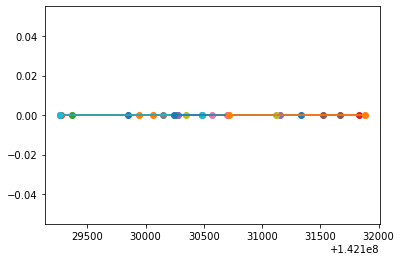

In [31]:
import matplotlib.pylab as plt
plt.figure()
for s_,e_ in zip(exon_starts,exon_ends):
    plt.plot([s_,e_],[0,0],'o-')

In [15]:
exon_starts-exon_ends

array([  -101,    -67,   -121,   -212,    -51,   -139,  -5106, -10726])

In [ ]:
###
https://docs.google.com/presentation/d/1moz-vBzbFBZ6UImobpoRZd0ULM6ELm91hgMju1NEg3s/edit#slide=id.gf91406a97a_0_8
    
https://docs.google.com/document/d/1_KfleKECGJChOOWJvPXGp74as5fZ2_cMD8AAtQ9sU18/edit